In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

# Howto
This notebook shows how to use the gpy test. It is used to test the hypothesis that a set of time series are decorrelated, under the assumption that all the time series have the same spectral density (plus some additional technical assumptions).

## Dataset
We will use the daily returns of the S&P 500 companies over the last 5 years.

In [2]:
dataset_path = Path("./data/snp_returns.csv")

In [3]:
# download the dataset if it does not exist
if not dataset_path.exists():
    # extract the list of S&P 500 companies from wikipedia
    wikipedia_data = pd.read_html(
        "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    )
    snp_company_list, snp_changes = wikipedia_data[0], wikipedia_data[1]
    snp_ticker_symbols = snp_company_list.Symbol.tolist()

    # download the close prices from yahoo finance
    data = yf.download(
        tickers=snp_ticker_symbols, start="2011-01-01", end="2011-12-31", interval="1d"
    )
    prices = data["Adj Close"]

    # compute the returns. Keep only the instruments with no NaN values
    prices = prices.dropna(axis=1, how="any")
    returns = np.log(prices).diff().dropna(axis=0, how="any")

    # dump returns as csv
    returns.to_csv(dataset_path)

# load the csv
returns = pd.read_csv(dataset_path, index_col=0)

[*********************100%***********************]  503 of 503 completed

59 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['NCLH', 'HPE', 'AMTM', 'VST', 'HLT', 'FOXA', 'IQV', 'EPAM', 'VLTO', 'GDDY', 'NOW', 'GEV', 'SW', 'LW', 'KHC', 'PLTR', 'SYF', 'UBER', 'ABNB', 'ALLE', 'NWSA', 'FOX', 'VICI', 'CRWD', 'AMCR', 'DAY', 'ANET', 'MRNA', 'CEG', 'ZTS', 'QRVO', 'CFG', 'FTV', 'IR', 'INVH', 'SOLV', 'FANG', 'ENPH', 'OTIS', 'DOW', 'CTLT', 'KEYS', 'GEHC', 'ABBV', 'CARR', 'PYPL', 'DELL', 'PSX', 'CZR', 'CDW', 'PAYC', 'HWM', 'META', 'NWS', 'PANW', 'CTVA', 'KVUE']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2011-01-01 -> 2011-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1293858000, endDate = 1325307600")')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2011-01-01 -> 2011-12-31)')


In [4]:
returns.shape

(251, 438)

In [5]:
# standardize the returns for each instrument
snp_ticker_symbols = returns.columns.tolist()
standardized_returns = {}
a_is, b_is, beta_is = {}, {}, {}
for ticker in snp_ticker_symbols:
    rs = returns[ticker]
    a_i = np.mean(rs)
    b_i = np.std(rs)
    standardized_returns[ticker] = (rs - a_i) / b_i
    a_is[ticker] = a_i
    b_is[ticker] = b_i

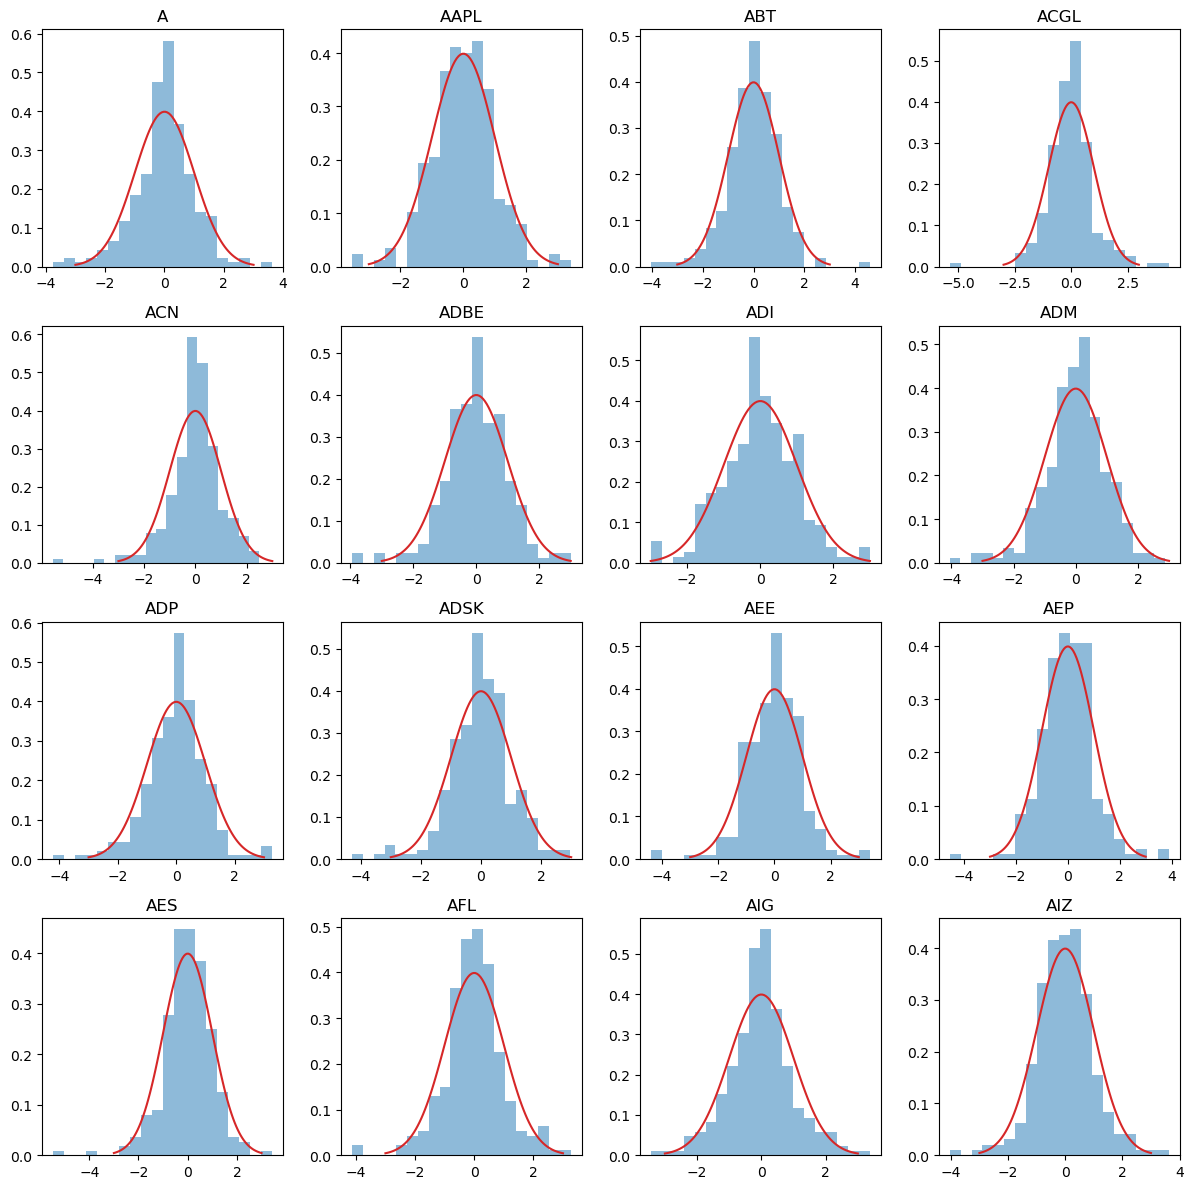

In [6]:
# plot for the first few instruments the standardize returns distribution against the gaussian with mean a_i and std b_i

n_graphs_to_plot = 4
fig, axs = plt.subplots(
    n_graphs_to_plot,
    n_graphs_to_plot,
    figsize=(3 * n_graphs_to_plot, 3 * n_graphs_to_plot),
)
# flatten the axs array
axs = axs.flatten()

# compute the gaussian pdf
x = np.linspace(-3, 3, 100)
gaussian_pdf = norm.pdf(x)

for i, ticker in enumerate(snp_ticker_symbols[: n_graphs_to_plot**2]):
    rs = standardized_returns[ticker]
    ax = axs[i]
    ax.hist(rs, bins=20, alpha=0.5, density=True)
    ax.plot(x, gaussian_pdf, label="Gaussian", color="tab:red")
    ax.set_title(ticker)

fig.tight_layout()

## GPY test
In this section, we run the GPY test against 50 randomly selected companies.

In [7]:
# the gpy test relies on the assumption that all time series share the same spectral density

from scipy.signal import periodogram

# convert returns to a 2D numpy array,
standardized_returns_np = np.array(
    [standardized_returns[ticker] for ticker in snp_ticker_symbols]
).T

# estimate the spectral density of the returns. Since we assume they are all the same,
# we can average the spectral density of each instrument
freqs, psd = periodogram(standardized_returns_np, axis=0)
avg_psd = np.mean(psd, axis=1)
idx = np.argsort(freqs)
freqs = freqs[idx]
avg_psd = avg_psd[idx]

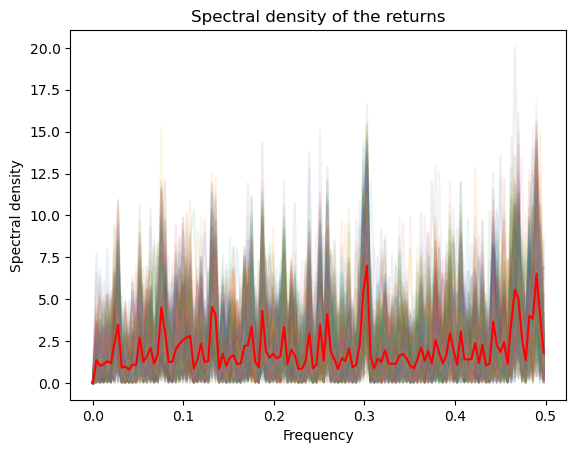

In [8]:
# plot the spectral density for each company (with a bit of transparency), and the average
fig, ax = plt.subplots()
for i in range(standardized_returns_np.shape[1]):
    ax.plot(freqs, psd[:, i], alpha=0.1)
ax.plot(freqs, avg_psd, color="red")
ax.set_xlabel("Frequency")
ax.set_ylabel("Spectral density")
ax.set_title("Spectral density of the returns");

In [9]:
from tqdm import tqdm
from gpy_test import GPY

# test functions to use in the test
fs = [lambda x: x, lambda x: x**2]


def run(N, M, repeat):
    companies_idx = np.random.choice(standardized_returns_np.shape[1], M, replace=False)
    selected_standardized_returns_np = standardized_returns_np[:N, companies_idx]

    # the null hypothesis (the daily returns of the selected comparnies are independent) is rejected
    gpy_results = GPY(selected_standardized_returns_np, fs, recenter=True)
    result = {
        "N": N,
        "M": M,
        "test_statistics": gpy_results.test_statistic,
        "repeat": repeat,
    }
    return result


# select randomly 50 companies, repeat 10 times
results = []

M_range = np.arange(5, 95, 5)
c = 0.5
n_repeats = 10
tasks = []
for M in M_range:
    N = int(M / c)
    tasks += [(N, M, repeat) for repeat in range(n_repeats)]

from joblib import Parallel, delayed

results = Parallel(n_jobs=-1)(delayed(run)(*task) for task in tqdm(tasks))

# display the results
df = pd.DataFrame(results)
df_mean = (
    df[["N", "M", "test_statistics"]].groupby(["N", "M"]).mean().reset_index(drop=False)
)
df_mean["repeat"] = "mean"
df = pd.concat([df, df_mean])
df.pivot(index=["N", "M"], columns=["repeat"], values=["test_statistics"])

100%|██████████| 180/180 [00:22<00:00,  7.92it/s]


test_statistics                                                  \
repeat               0            1           2           3          4   
N   M                                                                    
10  5         1.080366 -3111.732152 -620.757559    0.500301 -97.241189   
20  10       -8.680175     1.986395  -16.537592   20.097535  -4.681142   
30  15       -0.887824     0.935072    1.795762    1.001513   0.096485   
40  20        6.449459    -0.388925    7.228263    3.716558  28.760683   
50  25        7.833614     8.104139    1.135167   14.503118   7.189394   
60  30        0.293954     2.007566   15.148544    0.070805   2.553493   
70  35       19.405631     0.053588    1.687256    1.497830  35.861002   
80  40        0.293175    16.452927    1.902114    3.753825   2.154552   
90  45        0.503252     0.097443    0.836943    0.899474  16.436952   
100 50        0.155611     4.978864    1.998207   12.311464  26.988132   
110 55        1.914487     3.378054    2.856112    3.399471   4.513887   
120 60       18.518310     9.441614   12.979208    4.312058   0.494515   
130 65        0.335549    23.566833    0.050210    2.629484  17.939310   
140 70        2.094811     0.648778    1.471954    0.574380   3.027080   
150 75       16.321705     4.883098  263.996449    9.402892   3.166167   
160 80     -101.721966     5.132348   -1.113563 -212.308185   0.120938   
170 85       -1.806380    -8.569448  -47.479862   63.031940 -12.276103   
180 90      -16.668152   -36.452629  -11.996040   -7.639823 -11.877482   

                                                                                
repeat             5          6          7          8           9         mean  
N   M                                                                           
10  5  -90610.251459   1.047409   1.262586   0.851631    0.091966 -9443.514810  
20  10     -7.894707  19.068485  -4.887661   2.146455    0.372612     0.099020  
30  15      8.738731  16.526692   5.818745   9.078763   32.438672     7.554261  
40  20      0.754270   1.272590   8.485385   5.611127   29.363087     9.125250  
50  25     28.522805  69.660692   0.819319   1.838172    1.265737    14.087216  
60  30      4.993765   3.467923  20.206850  48.690404    9.673931    10.710724  
70  35      1.632982   0.235341   0.890989  22.264176   13.784906     9.731370  
80  40      2.145048   4.543084   1.371341  22.208749    0.103557     5.492837  
90  45      3.227399   0.476245   0.653827   0.739608    7.227425     3.109857  
100 50     15.351504   0.138182   1.326196   0.478146    0.361880     6.408819  
110 55      2.165386   6.523077   3.811708   5.715396    4.795279     3.907286  
120 60      0.062166   1.977138   3.053517   8.036972    3.029692     6.190519  
130 65      4.823385   4.936468   0.010550   4.230071    0.249536     5.877140  
140 70     14.645984   2.325317   9.587835   3.261693   63.258765    10.089660  
150 75     21.010226   1.142851  23.438162  87.394725    0.893108    43.164938  
160 80     40.860895  67.618829  -8.503733  -1.770117  -14.008109   -22.569266  
170 85    -36.218950  -3.559619 -45.265808  -6.499966   -7.887510   -10.653171  
180 90     -1.822088  -2.458702  27.612769  -0.335880  339.731490    27.809346

In [10]:
chi2.ppf(0.95, 2)

np.float64(5.99146454710798)

In [11]:
from gpy_test import GPY

# test functions to use in the test
fs = [lambda x: x, lambda x: x**2]

gpy_results = GPY(standardized_returns_np, fs)
gpy_results.test_statistic

0.12056012070713693